# Solving a Graph Partitioning Problem with Quantum

Notebook by Brian Lechthaler:
* https://github.com/brianlechthaler
* https://twitter.com/brianlechthaler
Heavily influenced by the following works:
* AWS Braket Examples https://github.com/aws/amazon-braket-examples/blob/main/quantum_annealing/Dwave_GraphPartitioning.ipynb
* D-Wave Ocean SDK Examples https://github.com/dwave-examples/graph-partitioning

## Part 1: Getting Started
### Part 1A: Introduction
In this notebook, we use D-Wave's Ocean SDK with the AWS Braket plugin to solve a graph partitioning problem on the D-Wave Advantage System 1.1 on AWS Braket. This graph partitioning problem is an example of a large problem with a very large number of variables -- something that would take a classical computer a very long amount of time, but would be no problem for a quantum computer. 

### Part 1B: Problem
We have n balls that we need to split into 2 groups. Some of the balls are red , some of them are blue. These teams must fit the following constraints:
* groups should be of equal size
* groups should be as separated by color as possible, with the smallest number of reds with blues and vice-versa.

### Part 1C: Solving with quantum
To solve this complex problem on a classical computer would likely take a completely impractical amount of time, but this kind of constraint-solving-problem is nothing short of optimal for NISQ-era quantum devices! We need to convert our graph problem into a Quadratic Unconstrained Binary Optimization (QUBO) problem, which is a format that our quantum annealer will be able to solve. Unlike it's classical ancestor, our annealer is able to execute all states almost instantly -- this is a complete ascendancy from the way classical computers solve problems in that classical computers must iterate over each operation, much slower than instantly having every iteration at once.

### Part 1D: Pre-requisites

*you must meet all pre-requisites before running this notebook to run this notebook without error.*

* The machine you are running this notebook on must have access to your AWS account either through instance-attached IAM policies(recommended) or credentials in a relevant configuration directory. 
  * Reminder: the role or user you create to run this notebook must be authorized to access to both Braket and the S3 bucket for your results.
* The bucket.py file included in the repo this notebook belongs to must be present in the same directory that you open this notebook from. Please go ahead and configure it right now to include the name of your S3 bucket from Braket onboarding if you have not already done so.

### Part 1A: Imports & Setup

In [1]:
import json
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
from collections import defaultdict
from itertools import combinations
import math
import time
import dwave_networkx as dnx
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite

### Part 1B: Configuration

In [2]:
#Task and machine specific config
dwave_qpu = 'Advantage_system1'
# we set this to 10, which is really low, but keeps the total cost of running this notebook low in exchange for less accuracy
shotPerTask = 10

In [3]:
#AWS specific config
from bucket import get_bucket as bucket
# Please enter the S3 bucket you created during onboarding in the code below
my_bucket = bucket() # the name of the bucket
my_prefix = "results" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

## Part 2: Define functions

### Part 2A: Helper function for plotting [1/2]

In [4]:
# helper function to plot graph
def get_graph(graph, 
              pos):
    """
    plot colored graph for given solution
    """
    # positions for all nodes
    # pos = nx.spring_layout(graph)

    # nodes
    nx.draw_networkx_nodes(graph, 
                           pos, 
                           node_size=200)

    # edges
    nx.draw_networkx_edges(graph, 
                           pos)

    # labels
    nx.draw_networkx_labels(graph, 
                            pos, 
                            font_size=10, 
                            font_family='sans-serif')

    # plot the graph
    plt.axis('off')
    #plt.savefig("figures/random_graph.png") # save as png
    plt.show();

### Part 2B: Helper function for plotting [2/2]

In [5]:
# helper function to plot graph
def get_colored_graph(graph, pos, colors):
    """
    plot colored graph for given solution
    """
    
    # positions for all nodes
    # pos = nx.spring_layout(graph)
    
    colorlist = ['#377eb8', '#e41a1c']
    nx.draw_networkx(graph, 
                     pos, 
                     node_color=[colorlist[colors[int(node)]] for node in graph.nodes],
                     node_size=200, 
                     font_weight='bold', 
                     font_color='w')
    # plot the graph
    plt.axis('off');
    # plt.savefig("./figures/weighted_graph.png") # save as png


### Part 2C: Generate a random graph

In [6]:
def mkg(gamma, vertices):
    G = nx.gnp_random_graph(vertices, 
                            0.2)
    get_graph(G, 
              nx.spring_layout(G))
    return G

### Part 2D: Convert graph into a QUBO dictionary

In [7]:
def mkdict(G, gamma):
    #init matrix
    Q = defaultdict(int)
    #fill matrix
    for u, v in G.edges:
        Q[(u,u)] += 1
        Q[(v,v)] += 1
        Q[(u,v)] += -2
    for i in G.nodes:
        Q[(i,i)] += gamma*(1-len(G.nodes))
    for i, j in combinations(G.nodes, 2):
        Q[(i,j)] += 2*gamma
    return Q

### Part 2E: Construct DWave Sampler

In [8]:
def mksampler():
    arn = 'arn:aws:braket:::device/qpu/d-wave/' + dwave_qpu
    sampler = BraketDWaveSampler(s3_folder, 
                                 arn)
    sampler = EmbeddingComposite(sampler)
    return sampler

### Part 2F: Define empty function so we can self-reference in our function without error

In [9]:
def dwsamp(G, 
           Q, 
           sampler, 
           gamma,
           nreads):
    return None

### Part 2G: Run task on QPU, then process response into a sample that we return

In [10]:
def dwsamp(G, 
           Q, 
           sampler, 
           gamma,
           nreads):
    print('[CPU -> QPU]: Sampling...')
    chain_strength = gamma*len(G.nodes)
    start = time.time()
    response = sampler.sample_qubo(Q, 
                                   chain_strength=chain_strength, 
                                   num_reads=nreads)
    end = time.time()
    timedelta = end - start
    print(f'[QPU -> CPU]: Quantum execution completed in {timedelta} seconds, processing response on CPU.')
    sample = response.record.sample[0]
    if sum(sample) in [math.floor(len(G.nodes)/2), 
                       math.ceil(len(G.nodes)/2)]:
        num_cut_edges = 0
        for u, v in G.edges:
            num_cut_edges += sample[u] + sample[v] - 2*sample[u]*sample[v]
        print("Valid partition found with", 
              num_cut_edges, 
              "cut edges.")
    else:
        print("Invalid partition.")
        print(f"Trying again with values:\nG={G};Q={Q}\nsampler={sampler}\ngamma={gamma}\nshots={nreads}")
        dwsamp(G, Q, sampler, gamma, nreads)
    return sample


### Part 2H: Process sample, output information about the solution

In [11]:
def process_sample(G, sample):
    pos = nx.spring_layout(G)
    get_graph(G, pos)
    colors = sample
    get_colored_graph(G, pos, colors)
    print(f'Raw sample data: {sample}')

### Part 2I: Tie all the above functions together into one unified function 

In [12]:
def run(gamma, 
        vertices,
        nreads):
    print('[1/5] Generating G value.')
    G = mkg(gamma, 
            vertices)
    print('[2/5] Generating Q value.')
    Q = mkdict(G, 
               gamma)
    print('[3/5] Generating DWave sampler. This may take a while.')
    sampler = mksampler()
    print('[4/5] Sampling on QPU.')
    sample = dwsamp(G, 
                    Q, 
                    sampler, 
                    gamma, 
                    nreads)
    print('[5/5] Processing samples taken from the QPU on the CPU.')
    process_sample(G,
                   sample)
    print('[END] All tasks completed.')
    return sample

## Part 3: Running experiments, determining AdvantageV1's limits, and marveling at the results

[1/5] Generating G value.


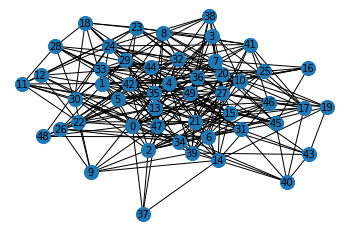

[2/5] Generating Q value.
[3/5] Generating DWave sampler. This may take a while.
[4/5] Sampling on QPU.
[CPU -> QPU]: Sampling...
[QPU -> CPU]: Quantum execution completed in 39.36744022369385 seconds, processing response on CPU.
Invalid partition.
Trying again with values:
G=;Q=defaultdict(<class 'int'>, {(0, 0): -3904, (5, 5): -3913, (0, 5): 158, (7, 7): -3908, (0, 7): 158, (10, 10): -3909, (0, 10): 158, (12, 12): -3914, (0, 12): 158, (13, 13): -3902, (0, 13): 158, (21, 21): -3905, (0, 21): 158, (22, 22): -3911, (0, 22): 158, (25, 25): -3910, (0, 25): 158, (27, 27): -3903, (0, 27): 158, (30, 30): -3909, (0, 30): 158, (32, 32): -3906, (0, 32): 158, (34, 34): -3910, (0, 34): 158, (37, 37): -3916, (0, 37): 158, (39, 39): -3908, (0, 39): 158, (48, 48): -3915, (0, 48): 158, (49, 49): -3909, (0, 49): 158, (1, 1): -3908, (2, 2): -3907, (1, 2): 158, (1, 5): 158, (1, 10): 158, (11, 11): -3911, (1, 11): 158, (1, 13): 158, (18, 18): -3911, (1, 18): 158, (24, 24): -3907, (1, 24): 158, (1, 25): 1

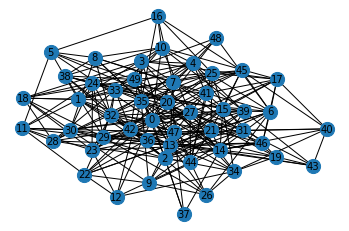

Raw sample data: [1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0
 0 1 0 1 1 1 1 0 1 0 0 1 1]
[END] All tasks completed.


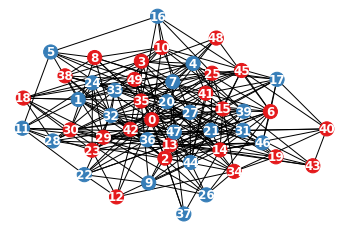

In [13]:
# the original d-wave documentation this algorithm was adapted from called for 50 vertices as default
sampleA = run(gamma=80, 
             vertices=50,
             nreads=shotPerTask)

[1/5] Generating G value.


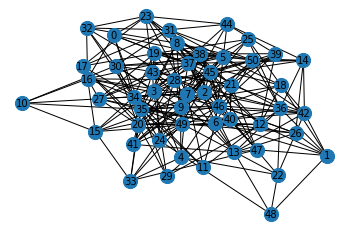

[2/5] Generating Q value.
[3/5] Generating DWave sampler. This may take a while.
[4/5] Sampling on QPU.
[CPU -> QPU]: Sampling...
[QPU -> CPU]: Quantum execution completed in 48.05439472198486 seconds, processing response on CPU.
Valid partition found with 125 cut edges.
[5/5] Processing samples taken from the QPU on the CPU.


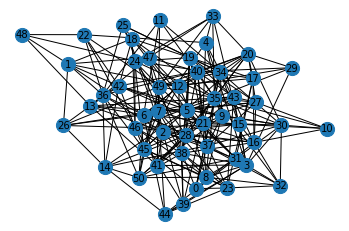

Raw sample data: [0 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1
 1 1 0 1 1 1 0 1 0 0 0 1 0 0]
[END] All tasks completed.


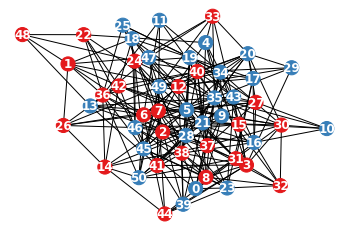

In [14]:
# let's start incrementally adding some vertices
sampleB = run(gamma=80, 
             vertices=51,
             nreads=shotPerTask)

[1/5] Generating G value.


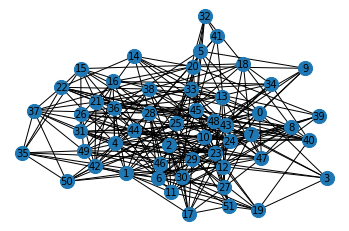

[2/5] Generating Q value.
[3/5] Generating DWave sampler. This may take a while.
[4/5] Sampling on QPU.
[CPU -> QPU]: Sampling...
[QPU -> CPU]: Quantum execution completed in 33.23802876472473 seconds, processing response on CPU.
Valid partition found with 140 cut edges.
[5/5] Processing samples taken from the QPU on the CPU.


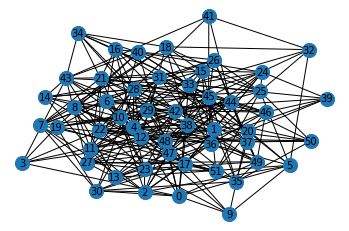

Raw sample data: [1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 1
 0 0 1 1 1 1 0 1 0 1 0 0 0 1 1]
[END] All tasks completed.


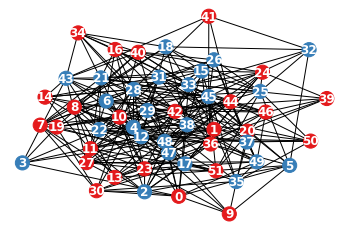

In [15]:
sampleC = run(gamma=80, 
             vertices=52,
             nreads=shotPerTask)

[1/5] Generating G value.


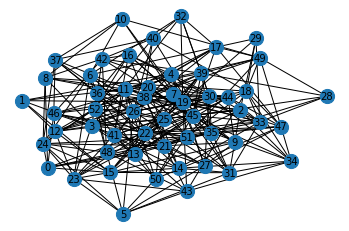

[2/5] Generating Q value.
[3/5] Generating DWave sampler. This may take a while.
[4/5] Sampling on QPU.
[CPU -> QPU]: Sampling...
[QPU -> CPU]: Quantum execution completed in 41.69132208824158 seconds, processing response on CPU.
Valid partition found with 122 cut edges.
[5/5] Processing samples taken from the QPU on the CPU.


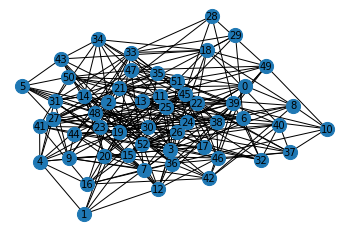

Raw sample data: [0 1 0 0 1 1 1 1 0 0 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0
 0 1 0 1 0 0 1 0 0 1 1 1 1 0 1 1]
[END] All tasks completed.


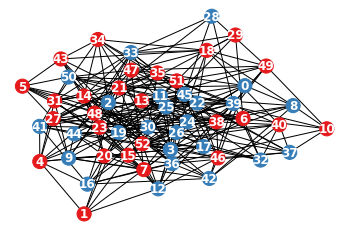

In [16]:
sampleD = run(gamma=80, 
             vertices=53,
             nreads=shotPerTask)

[1/5] Generating G value.


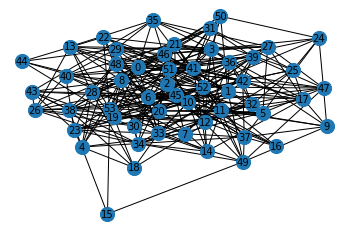

[2/5] Generating Q value.
[3/5] Generating DWave sampler. This may take a while.
[4/5] Sampling on QPU.
[CPU -> QPU]: Sampling...
[QPU -> CPU]: Quantum execution completed in 26.15481686592102 seconds, processing response on CPU.
Valid partition found with 140 cut edges.
[5/5] Processing samples taken from the QPU on the CPU.


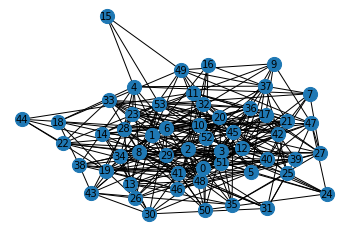

Raw sample data: [1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1
 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0]
[END] All tasks completed.


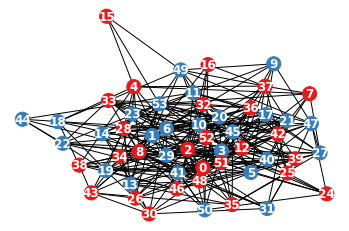

In [17]:
sampleE = run(gamma=80, 
             vertices=54,
             nreads=shotPerTask)

[1/5] Generating G value.


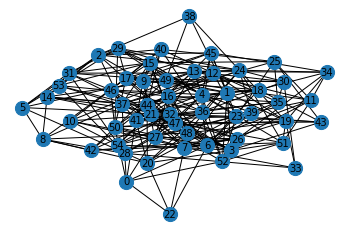

[2/5] Generating Q value.
[3/5] Generating DWave sampler. This may take a while.
[4/5] Sampling on QPU.
[CPU -> QPU]: Sampling...
[QPU -> CPU]: Quantum execution completed in 46.45263147354126 seconds, processing response on CPU.
Valid partition found with 130 cut edges.
[5/5] Processing samples taken from the QPU on the CPU.


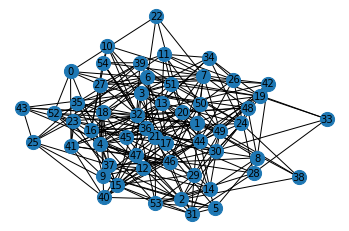

Raw sample data: [0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0
 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1]
[END] All tasks completed.


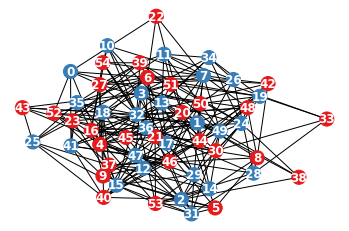

In [18]:
sampleF = run(gamma=80, 
             vertices=55,
             nreads=shotPerTask)

[1/5] Generating G value.


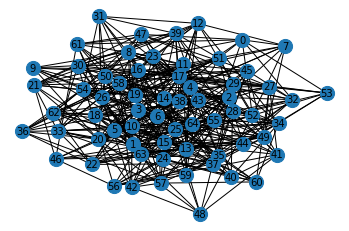

[2/5] Generating Q value.
[3/5] Generating DWave sampler. This may take a while.
[4/5] Sampling on QPU.
[CPU -> QPU]: Sampling...
[QPU -> CPU]: Quantum execution completed in 46.47705578804016 seconds, processing response on CPU.
Valid partition found with 209 cut edges.
[5/5] Processing samples taken from the QPU on the CPU.


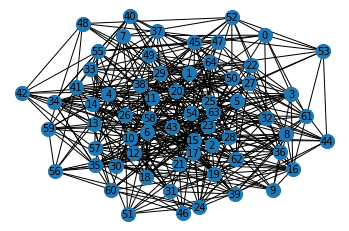

Raw sample data: [1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 1
 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1]
[END] All tasks completed.


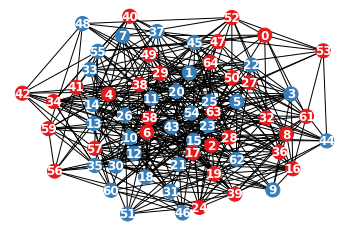

In [19]:
sampleG = run(gamma=80, 
             vertices=65,
             nreads=shotPerTask)

[1/5] Generating G value.


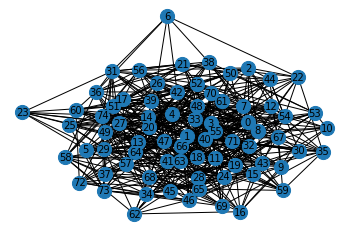

[2/5] Generating Q value.
[3/5] Generating DWave sampler. This may take a while.
[4/5] Sampling on QPU.
[CPU -> QPU]: Sampling...
[QPU -> CPU]: Quantum execution completed in 156.67604303359985 seconds, processing response on CPU.
Valid partition found with 273 cut edges.
[5/5] Processing samples taken from the QPU on the CPU.


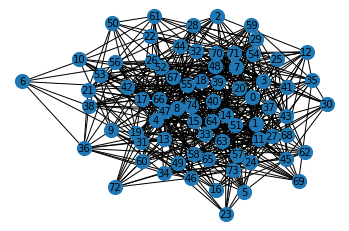

Raw sample data: [1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 1 0 1 0
 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0
 1]
[END] All tasks completed.


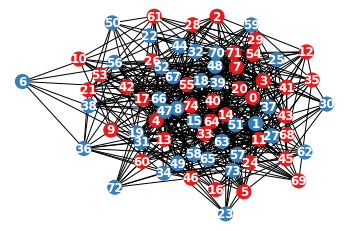

In [20]:
sampleH = run(gamma=80, 
             vertices=75,
             nreads=shotPerTask)

[1/5] Generating G value.


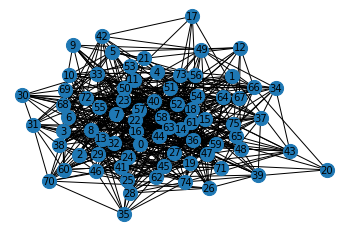

[2/5] Generating Q value.
[3/5] Generating DWave sampler. This may take a while.
[4/5] Sampling on QPU.
[CPU -> QPU]: Sampling...
[QPU -> CPU]: Quantum execution completed in 72.03496360778809 seconds, processing response on CPU.
Invalid partition.
Trying again with values:
G=;Q=defaultdict(<class 'int'>, {(0, 0): -5980, (3, 3): -5985, (0, 3): 158, (16, 16): -5982, (0, 16): 158, (18, 18): -5978, (0, 18): 158, (27, 27): -5986, (0, 27): 158, (31, 31): -5986, (0, 31): 158, (33, 33): -5983, (0, 33): 158, (36, 36): -5981, (0, 36): 158, (43, 43): -5989, (0, 43): 158, (45, 45): -5980, (0, 45): 158, (47, 47): -5983, (0, 47): 158, (48, 48): -5986, (0, 48): 158, (52, 52): -5981, (0, 52): 158, (55, 55): -5980, (0, 55): 158, (56, 56): -5985, (0, 56): 158, (60, 60): -5985, (0, 60): 158, (63, 63): -5982, (0, 63): 158, (68, 68): -5985, (0, 68): 158, (69, 69): -5982, (0, 69): 158, (73, 73): -5983, (0, 73): 158, (74, 74): -5983, (0, 74): 158, (1, 1): -5987, (1, 16): 158, (1, 18): 158, (1, 27): 158, (40

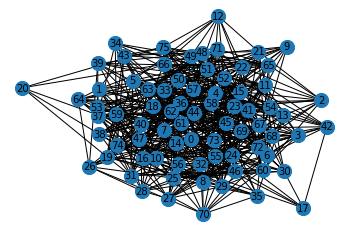

Raw sample data: [1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 1
 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1
 0 0]
[END] All tasks completed.


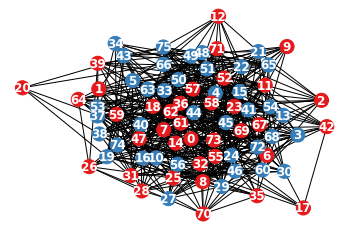

In [21]:
sampleI = run(gamma=80, 
             vertices=76,
             nreads=shotPerTask)

[1/5] Generating G value.


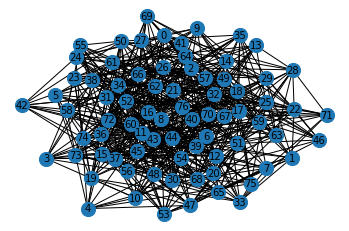

[2/5] Generating Q value.
[3/5] Generating DWave sampler. This may take a while.
[4/5] Sampling on QPU.
[CPU -> QPU]: Sampling...
[QPU -> CPU]: Quantum execution completed in 61.66605305671692 seconds, processing response on CPU.
Invalid partition.
Trying again with values:
G=;Q=defaultdict(<class 'int'>, {(0, 0): -6061, (2, 2): -6058, (0, 2): 158, (8, 8): -6055, (0, 8): 158, (9, 9): -6067, (0, 9): 158, (11, 11): -6061, (0, 11): 158, (16, 16): -6057, (0, 16): 158, (18, 18): -6059, (0, 18): 158, (24, 24): -6066, (0, 24): 158, (28, 28): -6067, (0, 28): 158, (32, 32): -6064, (0, 32): 158, (34, 34): -6061, (0, 34): 158, (36, 36): -6058, (0, 36): 158, (40, 40): -6061, (0, 40): 158, (41, 41): -6067, (0, 41): 158, (57, 57): -6064, (0, 57): 158, (60, 60): -6058, (0, 60): 158, (61, 61): -6060, (0, 61): 158, (66, 66): -6059, (0, 66): 158, (67, 67): -6069, (0, 67): 158, (69, 69): -6067, (0, 69): 158, (1, 1): -6069, (1, 9): 158, (1, 11): 158, (22, 22): -6063, (1, 22): 158, (29, 29): -6063, (1, 29)

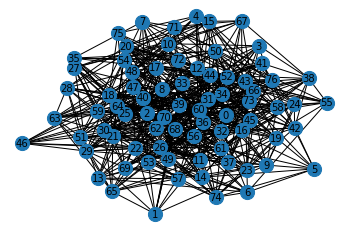

Raw sample data: [1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1
 1 1 1 0 0 1 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1
 0 1 1]
[END] All tasks completed.


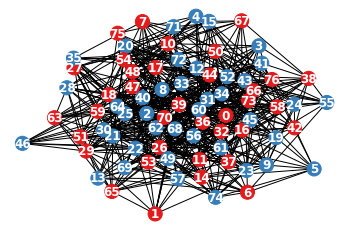

In [22]:
sampleJ = run(gamma=80, 
             vertices=77,
             nreads=shotPerTask)

**Notebook by Brian Lechthaler**

GP3 v3 | 2020-12-12 | please do not redistribute without attribution
* https://twitter.com/brianlechthaler
* https://github.com/brianlechthaler
* This notebook belongs to this repository: https://github.com/brianlechthaler/QuantumSolutions